# Case 2 - model 1
28.2.2021 Marja Satukangas<br>
Metropolia UAS

## 1. Introduction
In this notebook I'm using a chest x-ray images dataset loaded from Kaggle https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. The dataset indicates whether a person has a pneumonia or not. The aim of this notebook is to create CNN model that can predict the occurance of pneumonia based on the an x-ray image as accurately as possible.

Different models (1, 2 and 3) are created and results are compared at the end. This notebook represents the model number 1 and the purpose of this first notebook of the case is just do some experiment of the topic and get familiar with convolutional models and Kaggle. 


In [1]:
#Importing necessary libraries

import numpy as np 
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

print("tensorflow: ", tf.__version__)

tensorflow:  2.4.1


## 2. Dataset
The dataset consists of three folders: train, test and validation folders. All the folders have two subfolders "normal" and "pneumonia", which contain x-ray images. The classnames indicate the occurance of pneumonia in the image. Train dataset has 5216 samples, validation set 16 samples and test set 624 samples.

In [2]:
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
#val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"

In [3]:
batch_size = 32
img_height = 180
img_width = 180

### Loading data
Data is loaded as tensorflow.data.Dataset, which returns batches of images with labels. The validation set in the x-ray image folder is not used because it has only 16 images. The training set is splitted so that 20% of it is used for validation and 80% for training. Test data is used as it was in the data folder. Test set has 624 samples while train set and validation set has 5216 samples alltogether so test set is about 11% of entire dataset used.

In [4]:
# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size = (img_height, img_width))

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


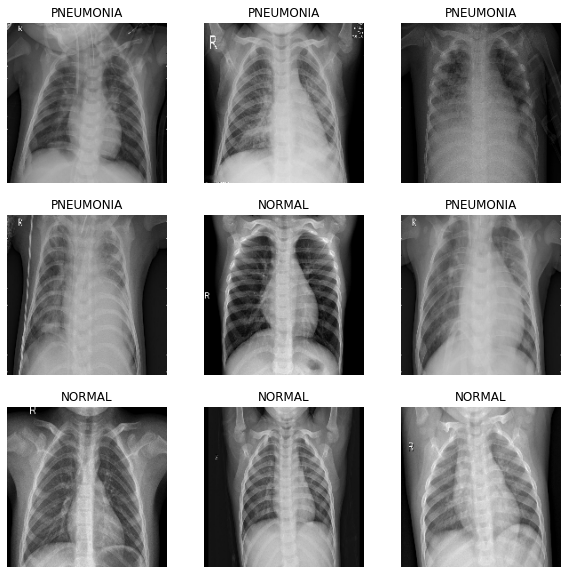

In [6]:
# show some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 3. Preprocessing

### Prefetch transformation

T[](http://)ransformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. 

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds =  test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation
Data augmentation is used to get more data and variation to the training data. It helps to reduce overfitting and makes the model more accurate. Because x-ray images are usually quite similar and no flipping and only a little rotation is occuring, augmentation is done only limitedly. In this model some random rotation and random zoom is added.  

Data augmentation is inactive at test time so input images will only be augmented during calls to model.fit.

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, fill_mode='constant'),
])

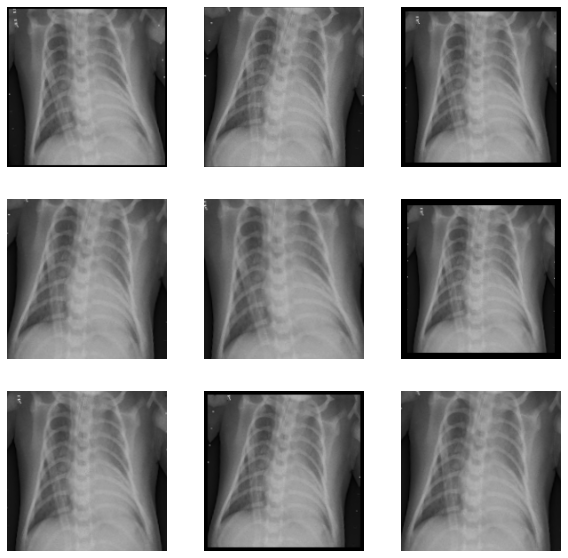

In [9]:
# Check how the data augmentation works
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 4. Modeling

First comes rescaling layer, which rescales pixel values of images to 0-1 and tells the model which size the input data is and what is the color mode. Data is fed to the model in batches consisting of 32 samples.   

After first layer, comes augmentation layer and then pooling layers and convolutional layers are taking turns. Last becomes dense layers.

Pooling layers between convolutional layers reduce the width and height of the representation and the computation that must be done.

At the end there are two dense layers for tuning and to compute the final output. In convolutional layers padding is set to 'same', which means that there is a padding evenly on left/right and top/bottom.


In [10]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

## 5. Training

Training is done with 6 epochs. First the train data was trained with 8 epochs but that caused overfitting. Then I changed epochs to 6 and model worked better.

In [11]:
%%time

epochs = 6

history = model.fit(      
      train_ds,
      validation_data = val_ds,
      verbose = 0,
      epochs = epochs
      )

print('Batch size = ', batch_size)


Batch size =  32
CPU times: user 28min 10s, sys: 1min 48s, total: 29min 59s
Wall time: 8min 46s


## 6. Evaluation and performance

Below there are plots of loss value and accuracy. From those one can see how the values change during training. 

In [13]:
#Accuracy of validation
model.evaluate(val_ds)

33/33 [==============================] - 6s 181ms/step - loss: 0.0757 - accuracy: 0.9703


[0.07571670413017273, 0.9702780246734619]

In [14]:

def plot_loss(h):
    
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='validation')
    plt.title('Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
def plot_accuracy(h):
    
    plt.plot(h.history['accuracy'], label='train')
    plt.plot(h.history['val_accuracy'], label='validation')
    plt.title('Training accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    

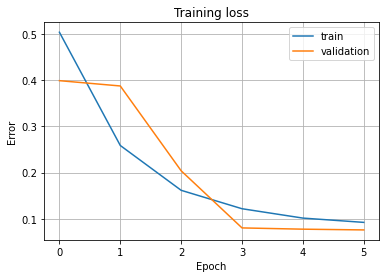

In [15]:
plot_loss(history)

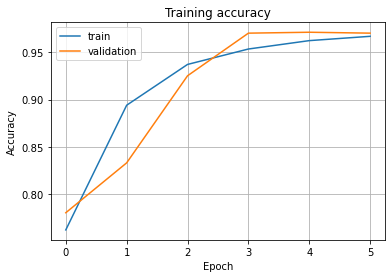

In [16]:
plot_accuracy(history)

In [21]:
#Test results
test_results = model.evaluate(test_ds)
test_results

20/20 [==============================] - 11s 395ms/step - loss: 0.6135 - accuracy: 0.7917


[0.6134820580482483, 0.7916666865348816]

## 7. Conclusions

This model can predict pneumonia accurately for validation set. Accuracy for validation set is 0,97 but for some reason model doesn't work for test set very well (loss 0.6 and accuracy 0.8).